# Movies classification demo

NLTK contains a "Movie Review" corpus containing 2000 movie reviews classified in "positive" and "negative" reviews.

Here we want to use NLP to learn to automatically classify good and bad movies, based on individual reviews.

In [1]:
# A few useful imports.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

We'll start by loading the raw texts and the review class ("pos" or "neg") in two lists.

In [2]:
# Importing the "Movie Reviews" corpus.
from nltk.corpus import movie_reviews

# A snippet of text from one of the reviews the corpus.
text = movie_reviews.raw(fileids=movie_reviews.fileids()[13])
print text[:400]

a movie like mortal kombat : annihilation works ( and must be reviewed on ) multiple levels . 
first , there's the rampant usage of randian subtext that pervades the entire movie . 
but occasionaly , almost as if making an ironic , self-depreciating remark , the movie tosses in clearly marxist imagery . 
no no . . . 
just kidding . 
had you going there for a moment , didn't i ? 
in all seriousness


In [3]:
# Collect all reviews and their label ("pos" or "neg") from the corpus.
reviews = []
labels = []
for file_id in movie_reviews.fileids():
    reviews.append(movie_reviews.raw(file_id))
    labels.append(movie_reviews.categories([file_id])[0])

We should have a look at some basic statistics: do reviews contain enough information to be useful? Is the data set balanced?

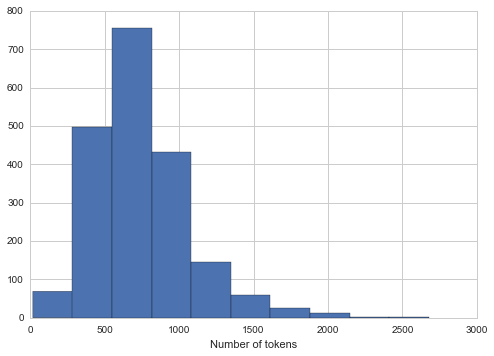

In [4]:
# Reviews are quite lengthy, so there should be enough information in each.
review_lengths = [len(review.split()) for review in reviews]
plt.hist(review_lengths)
plt.xlabel('Number of tokens'.format(len(reviews)));

In [5]:
# It's a balanced data set with 1000 positive and 1000 negative reviews.
n_pos = (np.array(labels) == 'pos').sum()
n_neg = len(labels) - n_pos
print "Number of positive reviews = {}; negative reviews = {}".format(n_pos, n_neg)

Number of positive reviews = 1000; negative reviews = 1000


We set aside 30% of the data set to test the classifier.

In [6]:
# Divide the data into a training and a test set.
from sklearn.cross_validation import train_test_split
# Fixed to make the notebook reproducible.
random_state = np.random.RandomState(3939)

test_set_fraction = 0.3
reviews_train, reviews_test, t_train, t_test = train_test_split(
    reviews, labels, test_size=test_set_fraction, random_state=random_state)
print '# train data points = {}, # test = {}'.format(len(reviews_train), len(reviews_test))

# train data points = 1400, # test = 600


To extract features from the reviews, we are going to use word counts after normalizing to lowercase and removing stopwords.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english', lowercase=True, binary=False, min_df=0.01)
features_train = vectorizer.fit_transform(reviews_train)

In [11]:
# How long is each feature vector?
print 'Number of features:', features_train.shape[1]

Number of features: 4563


In [13]:
# Print a sample of features.
print vectorizer.get_feature_names()[::200]

[u'000', u'anger', u'belief', u'caring', u'commentary', u'currently', u'disney', u'esque', u'finished', u'grant', u'hours', u'jeff', u'line', u'mickey', u'novel', u'pig', u'pure', u'richard', u'set', u'spirited', u'suspects', u'treated', u'waitress']


A Naive Bayes classifier is fit on the training set.

In [14]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(features_train, t_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Now we can measure the performance on the test set:

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
feature_test = vectorizer.transform(reviews_test)
classifier.score(feature_test, t_test)

0.82999999999999996

In [16]:
y_test = classifier.predict(feature_test)
confusion_matrix(t_test, y_test)

array([[240,  46],
       [ 56, 258]])

In [17]:
print classification_report(t_test, y_test)

             precision    recall  f1-score   support

        neg       0.81      0.84      0.82       286
        pos       0.85      0.82      0.83       314

avg / total       0.83      0.83      0.83       600



A common question for this kind of data is: which features are most predictive of a positive or negative review? 

The classifier object contains the log probability of a feature given a class, P(feature_i | class), and the log probability of a class P(class). This information can be combined to get P(class | feature_i):

P(class | feature_i) = P(feature_i | class) P(class) / Z

In [18]:
p = np.exp(classifier.feature_log_prob_ + classifier.class_log_prior_[:, None])
p = p / p.sum(0)

We want to print the features for which the probability of class "pos" is much higher than class "neg", and vice versa.

In [19]:
ratio = p[0, :] / p[1, :]
rank_idx = np.argsort(ratio)

In [20]:
feature_names = np.array(vectorizer.get_feature_names())

print 'Words indicating bad movies'
row = '{:>20s},  pos : neg,  1.0 : {:.1f}'
for idx in range(len(feature_names)-1, len(feature_names)-6, -1):
    factor = ratio[rank_idx[idx]]
    print row.format(feature_names[rank_idx[idx]], factor)

print 'Words indicating good movies'
row = '{:>20s},  pos : neg,  {:.1f} : 1.0'
for idx in range(5):
    factor = 1.0 / ratio[rank_idx[idx]]
    print row.format(feature_names[rank_idx[idx]], factor)


Words indicating bad movies
              seagal,  pos : neg,  1.0 : 25.0
          schumacher,  pos : neg,  1.0 : 18.4
           stupidity,  pos : neg,  1.0 : 15.4
               sucks,  pos : neg,  1.0 : 13.2
             idiotic,  pos : neg,  1.0 : 12.9
Words indicating good movies
             courage,  pos : neg,  19.1 : 1.0
              avoids,  pos : neg,  14.5 : 1.0
            religion,  pos : neg,  11.8 : 1.0
               damon,  pos : neg,  9.8 : 1.0
              finest,  pos : neg,  9.1 : 1.0


In [23]:
wrong = y_test != t_test

In [24]:
prob_test = classifier.predict_proba(feature_test)


In [30]:
np.where((y_test=='pos') & (np.array(t_test)=='neg'))

(array([  1,   8,  26,  33,  52,  84,  89,  97, 120, 152, 175, 176, 180,
        181, 195, 202, 210, 226, 227, 248, 259, 269, 297, 323, 337, 341,
        344, 353, 373, 399, 417, 419, 420, 430, 459, 487, 490, 507, 510,
        516, 517, 541, 550, 564, 566, 567]),)

In [33]:
movie_reviews.raw(fileids=movie_reviews.fileids()[550])

u"disillusioned and trying to find the spice of life , richard ( leonardo dicaprio ) sets off for thailand . \nthere he a meets crazed man by the name of daffy ( robert carlyle ) who gives him a map to a beach , a secret utopia , then commits suicide . \nrichard sets off for this beach with his neighbors from this hotel , ? tienne ( guillaume canet ) and fran ? oise ( virginie ledoyen ) . \nonce they get there the three discover a secret society existing on this beach , there richard falls for fran ? oise . \nthis covers about half to two thirds of the movie and aside from the romantic element , which is solely a creation of hollywood , seems to hold to the original novel . \nthe cinematography and general beauty of this part of the movie is breathtaking . \ni don't think anyone can argue that this movie is visually stunning . \nbut that is were many things go wrong , darius khondji has totally outdone himself in doing the cinematography . \nthough the script and the interpretation of 